In [17]:
import wmfdata as wmf

In [18]:
wmf.charting.set_mpl_style()

## Diagnosis

At the moment (11 Nov 2021), there are two tables where I have collected events from the experiment: `neilpquinn.kaios_experiment_event` (NPQ) and `nshahquinn.kaios_experiment_event` (NSQ). I started saving data to NSQ because I realized I had left out an important field (`wiki`). NSQ contains all the data that was still available when I had that realization. As a result, there is about a month and a half of overlap between the two tables.

It turns out that NPQ table seems to have two copies of each event from the first insert (for [2021-05-06, 2021-07-27]). Only when we filter those duplicates out does the event count during the time overlap match up.

In [19]:
npq_events = wmf.presto.run("""
SELECT
    DATE(FROM_ISO8601_TIMESTAMP(server_dt)) AS time,
    COUNT(*) AS npq_events
FROM neilpquinn.kaios_experiment_event
GROUP BY
    DATE(FROM_ISO8601_TIMESTAMP(server_dt))
ORDER BY time
""").set_index("time")

In [20]:
nsq_events = wmf.presto.run("""
SELECT
    DATE(FROM_ISO8601_TIMESTAMP(server_dt)) AS time,
    COUNT(*) AS nsq_events
FROM nshahquinn.kaios_experiment_event
GROUP BY
    DATE(FROM_ISO8601_TIMESTAMP(server_dt))
ORDER BY time
""").set_index("time")

In [21]:
npq_unique_events = wmf.presto.run("""
WITH unique_events AS (
    SELECT DISTINCT *
    FROM neilpquinn.kaios_experiment_event
)
SELECT
    DATE(FROM_ISO8601_TIMESTAMP(server_dt)) AS time,
    COUNT(*) AS npq_unique_events
FROM unique_events
GROUP BY
    DATE(FROM_ISO8601_TIMESTAMP(server_dt))
ORDER BY time
""").set_index("time")

In [22]:
nsq_unique_events = wmf.presto.run("""
WITH unique_events AS (
    SELECT DISTINCT *
    FROM nshahquinn.kaios_experiment_event
)
SELECT
    DATE(FROM_ISO8601_TIMESTAMP(server_dt)) AS time,
    COUNT(*) AS nsq_unique_events
FROM unique_events
GROUP BY
    DATE(FROM_ISO8601_TIMESTAMP(server_dt))
ORDER BY time
""").set_index("time")

In [23]:
daily_events = (
    npq_events
    .merge(nsq_events, how="outer", right_index=True, left_index=True)
    .merge(npq_unique_events, how="outer", right_index=True, left_index=True)
    .merge(nsq_unique_events, how="outer", right_index=True, left_index=True)
    .fillna(0)
    .applymap(int)
)

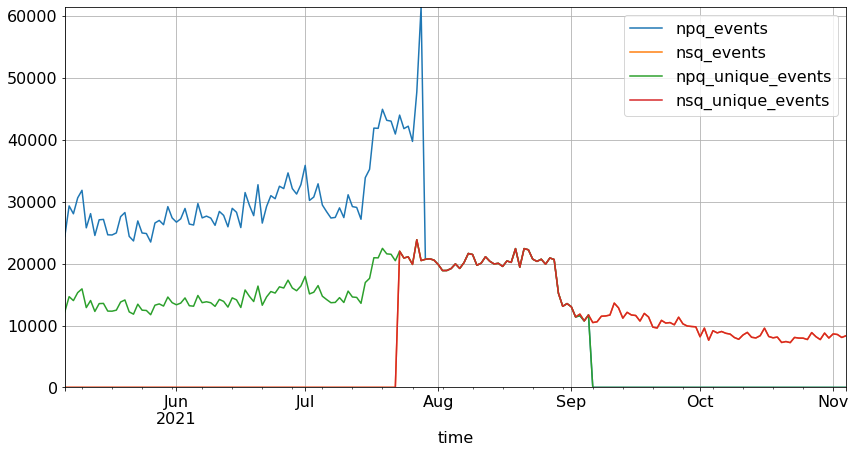

In [24]:
daily_events.plot();

In [25]:
daily_events.query("time >= '2021-07-12' and time < '2021-08-01'")

,npq_events,nsq_events,npq_unique_events,nsq_unique_events
time,,,,
2021-07-12,29222,0,14611,0
2021-07-13,29090,0,14545,0
2021-07-14,27176,0,13588,0
2021-07-15,33900,0,16950,0
2021-07-16,35254,0,17627,0
2021-07-17,41910,0,20955,0
2021-07-18,41872,0,20936,0
2021-07-19,44952,0,22476,0
2021-07-20,43170,0,21585,0


## Fix

I create a new table, `nshahquinn.kaios_experiment_event_combined`, excluding NSQ's `dt` field, since it just duplicates `server_dt`/`meta.dt`. I will also take the opportunity to make `client_dt` and `server_dt` into real timestamp rather than strings.

In [ ]:
wmf.spark.run("""
CREATE TABLE nshahquinn.kaios_experiment_event_combined (
    client_dt TIMESTAMP,
    server_dt TIMESTAMP,
    pageview_id STRING,
    session_id STRING,
    user_id STRING,
    load_dt STRING,
    page_open_time BIGINT,
    page_visible_time BIGINT,
    section_count BIGINT,
    opened_section_count BIGINT,
    is_main_page BOOLEAN,
    page_namespace BIGINT,
    wiki STRING,
    experiment_group STRING,
    country STRING,
    country_subdivision STRING,
    app_version STRING
) STORED AS PARQUET
""")

First, I insert the NPQ events until 2021-07-23, the day the NSQ events start.

In [ ]:
wmf.spark.run("""
WITH unique_events AS (
    SELECT DISTINCT *
    FROM neilpquinn.kaios_experiment_event
)
INSERT INTO TABLE nshahquinn.kaios_experiment_event_combined
SELECT
    TO_TIMESTAMP(client_dt) AS client_dt,
    TO_TIMESTAMP(server_dt) AS server_dt,
    pageview_id,
    session_id,
    user_id,
    load_dt,
    page_open_time,
    page_visible_time,
    section_count,
    opened_section_count,
    is_main_page,
    page_namespace,
    NULL as wiki,
    experiment_group,
    country,
    country_subdivision,
    app_version
FROM unique_events
WHERE TO_DATE(server_dt) < '2021-07-23'
""")

Next, I insert the NSQ events.

In [ ]:
wmf.spark.run("""
INSERT INTO TABLE nshahquinn.kaios_experiment_event_combined
SELECT
    TO_TIMESTAMP(client_dt) AS client_dt,
    TO_TIMESTAMP(server_dt) AS server_dt,
    pageview_id,
    session_id,
    user_id,
    load_dt,
    page_open_time,
    page_visible_time,
    section_count,
    opened_section_count,
    is_main_page,
    page_namespace,
    wiki as wiki,
    experiment_group,
    country,
    country_subdivision,
    app_version
FROM nshahquinn.kaios_experiment_event
""")

In [28]:
combined_events = wmf.presto.run("""
SELECT
    DATE(server_dt) AS time,
    COUNT(*) AS combined_events
FROM nshahquinn.kaios_experiment_event_combined
GROUP BY
    DATE(server_dt)
ORDER BY time
""").set_index("time")

daily_events = daily_events.merge(combined_events, how="outer", right_index=True, left_index=True)

Okay, now we have one consolidate table of events without a bunch of duplicates!

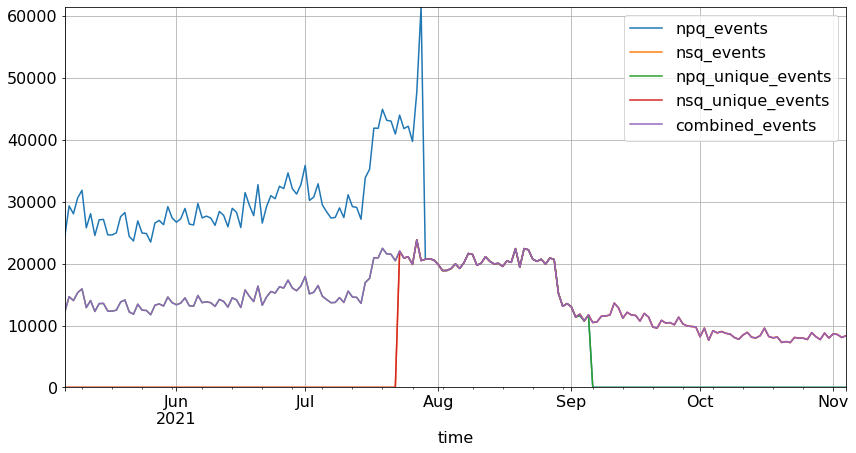

In [29]:
daily_events.plot();